# Surface Meshing

This example demonstrates how to construct a geometry, surface mesh, and DAGMC model using Stellarmesh along with an OpenMC tally.

In [7]:
import tempfile

import build123d as bd
from IPython.display import Image

import stellarmesh as sm

In [8]:
def render_mesh(mesh: sm.Mesh):
    """Render a Stellarmesh mesh to the notebook output."""
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
        mesh.render(tmp_file.name, rotation_xyz=(90, 0, -90), normals=0, clipping=True)
        display(Image(tmp_file.name, width=800))

## Model Geometry with build123d

Geometry is initialized in Stellarmesh with the [Geometry](../../api/geometry.rst) class. Here, we construct a layered torus model with [build123d](https://github.com/gumyr/build123d), but [CadQuery](https://github.com/CadQuery/cadquery) solids are equally supported. The length of ``material_names`` must match the length of ``solids``. 

In [9]:
def build_torus_geometry():
    """Example torus geometry with 2 concentric layers."""
    solids = [bd.Solid.make_torus(10, 1).solid()]
    for _ in range(2):
        solids.append(bd.thicken(solids[-1].faces()[0], 1).solid())
    solids = solids[1:]
    return sm.Geometry(solids, material_names=["a", "b"])

## Mesh Geometry

We create a surface mesh for our geometry using the [SurfaceMesh](../../api/mesh.rst) ``from_geometry`` constuctor, which takes as a second parameter the meshing backend of our choice. Here, we use the OCC meshing backend with an angular tolernace of 1 degree.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


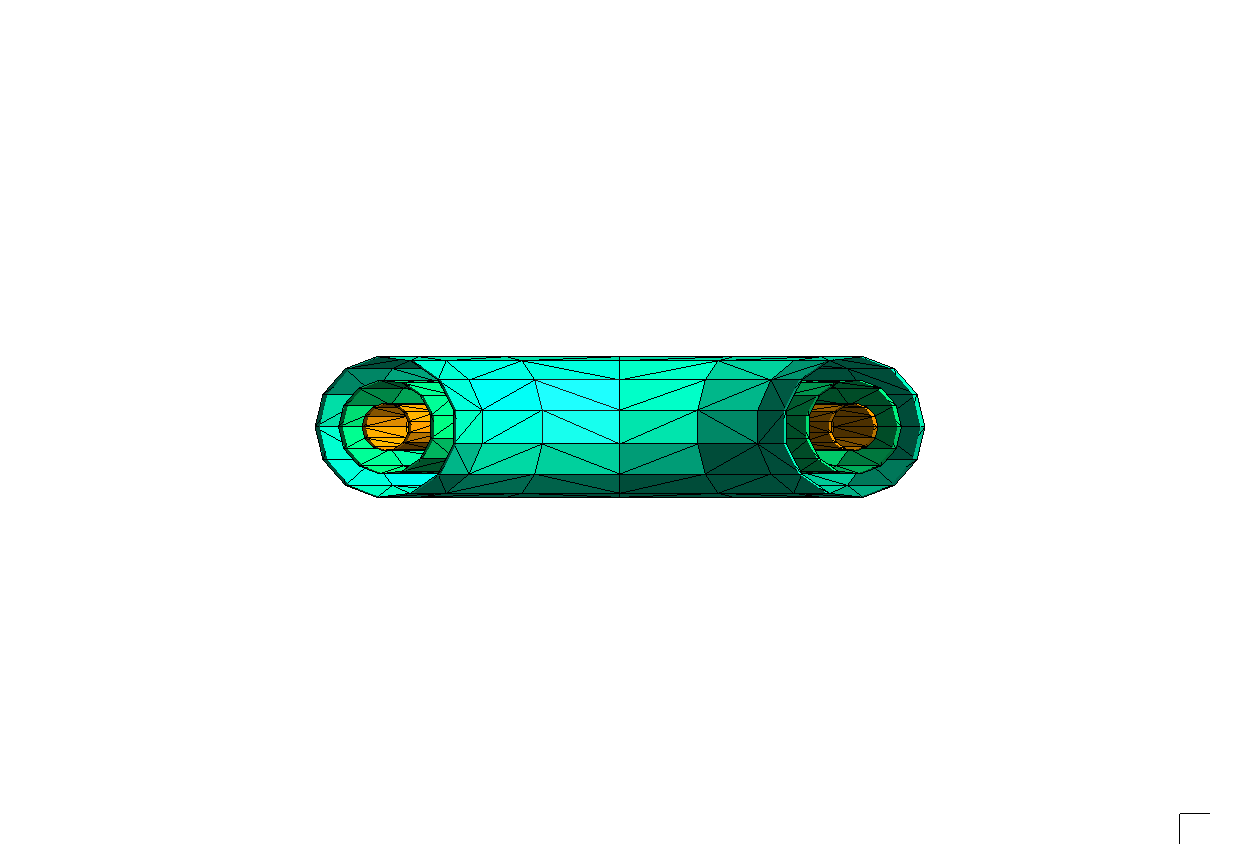

In [10]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=1, tol_linear=None)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

Decreasing the angular tolernace to 0.5 degrees gives us a higher resolution mesh.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


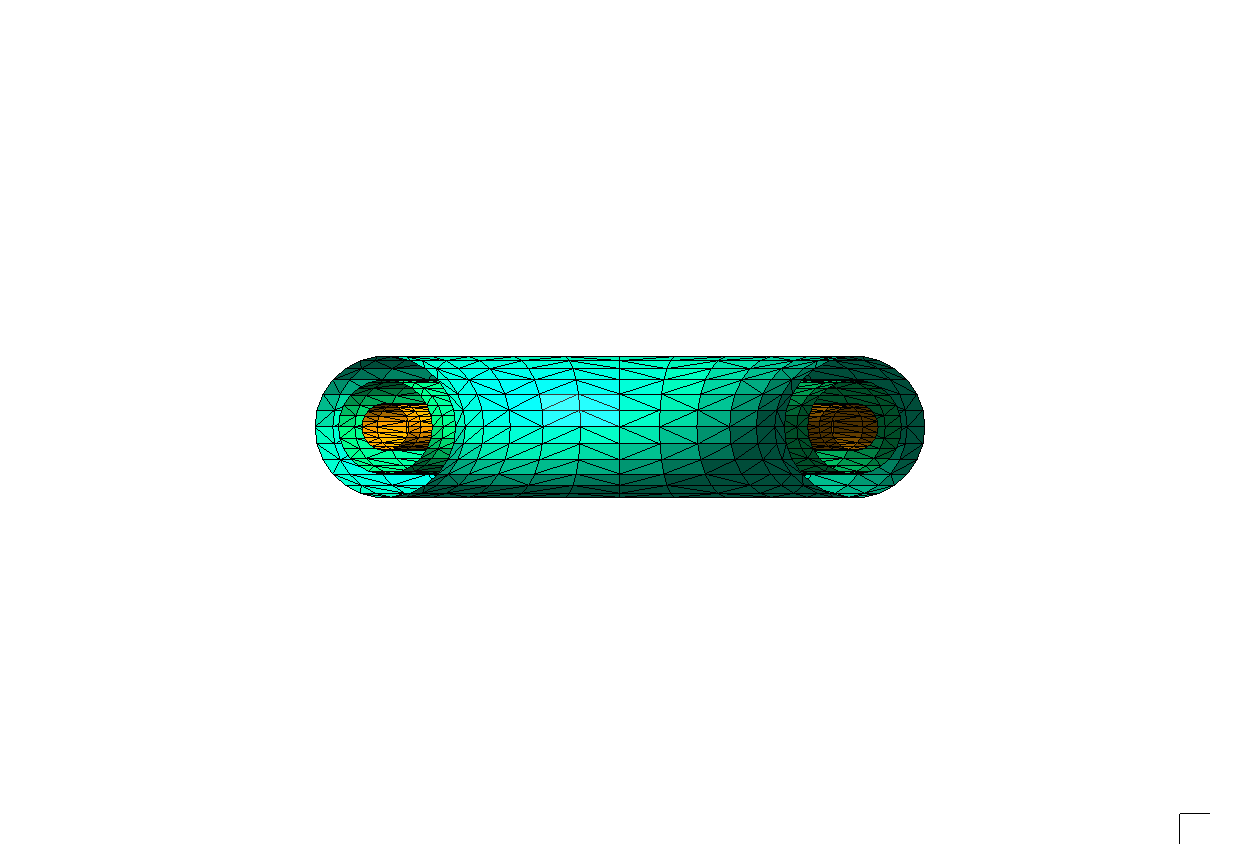

In [11]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=0.5, tol_linear=None)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

### Linear tolerance
We can also specify a linear tolerance. Here, we assert that the generated mesh must lie within 0.05 units of the true surface.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


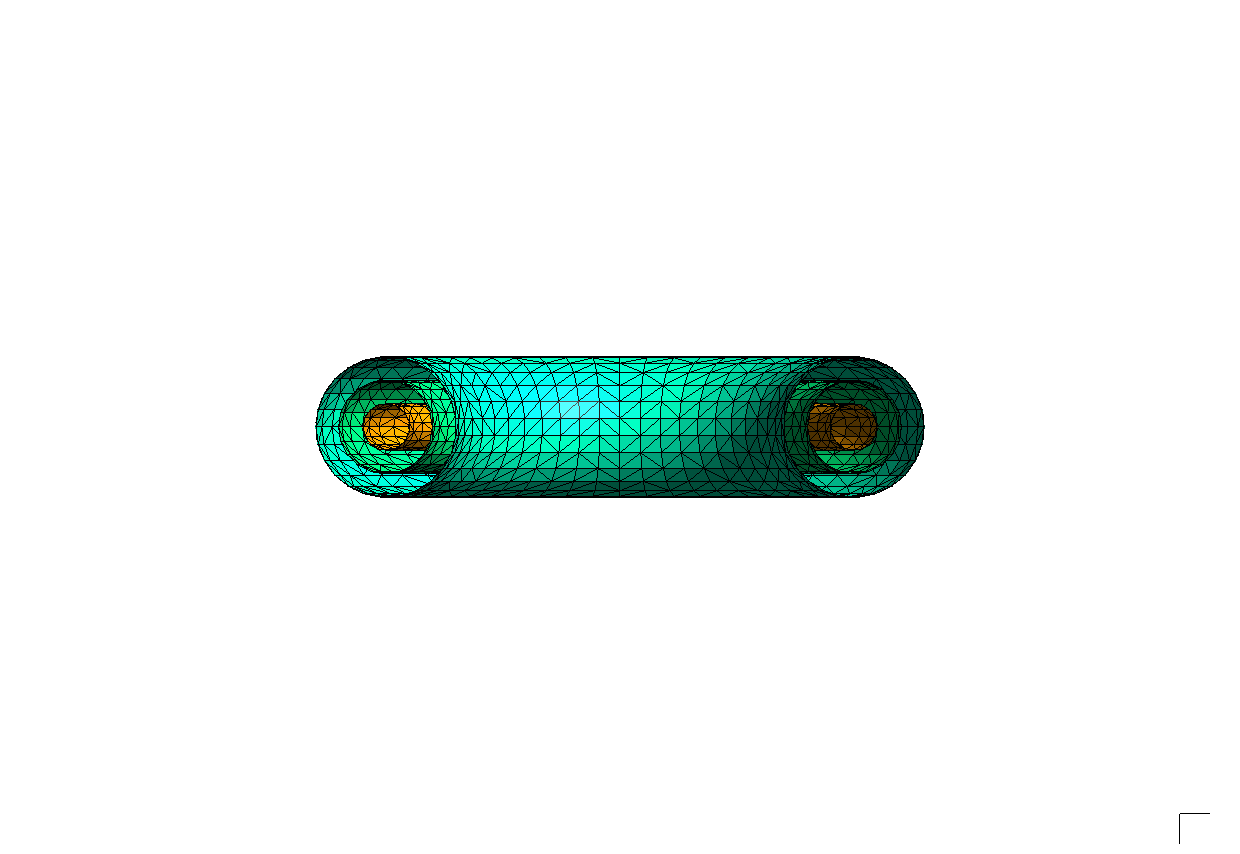

In [12]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=None, tol_linear=0.05)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

## Mesh With Gmsh

It is also possible to mesh geometries using Gmsh surface meshing algorithms. These algorithms generate high quality elements. However, Gmsh does not support specifying exact tolerances.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


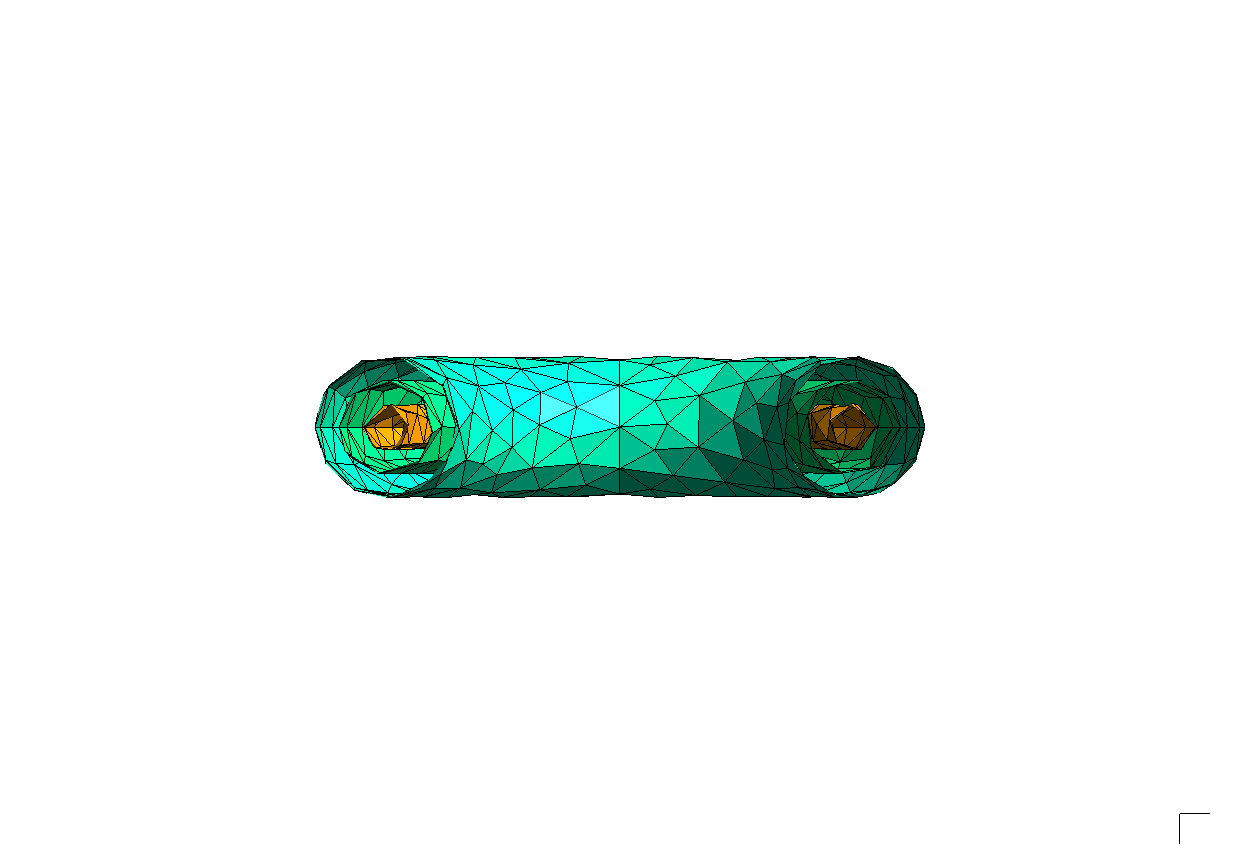

In [13]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(min_mesh_size=0.5, max_mesh_size=2)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)
display(Image("mesh.png", width=800))

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


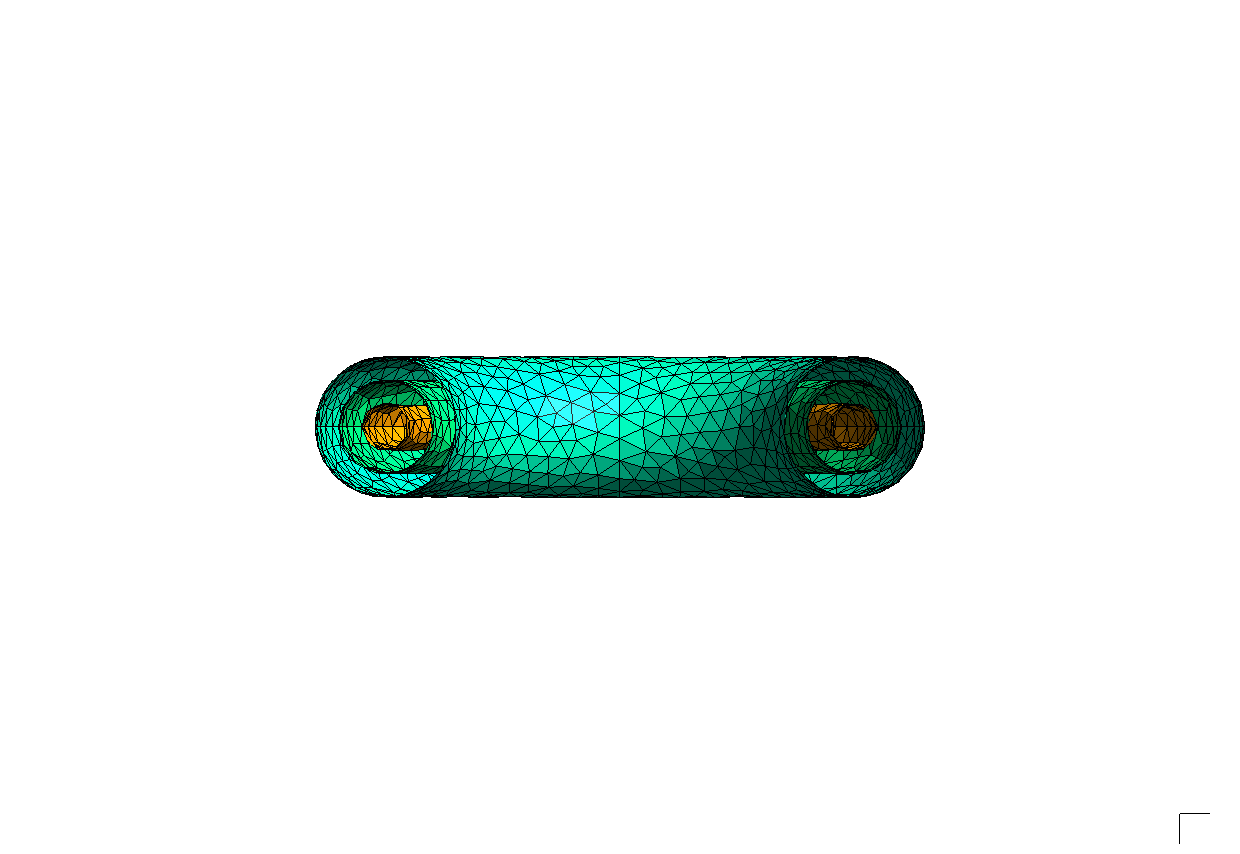

In [14]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(min_mesh_size=0.5, max_mesh_size=1)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)

display(Image("mesh.png", width=800))

### Curvature Target

The `curvature_target` option allows us to specify a target number of mesh elements per 2pi radians. This approximates an angular tolerance parameter. Note that regions of higher curvature now have a finer mesh resolution.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


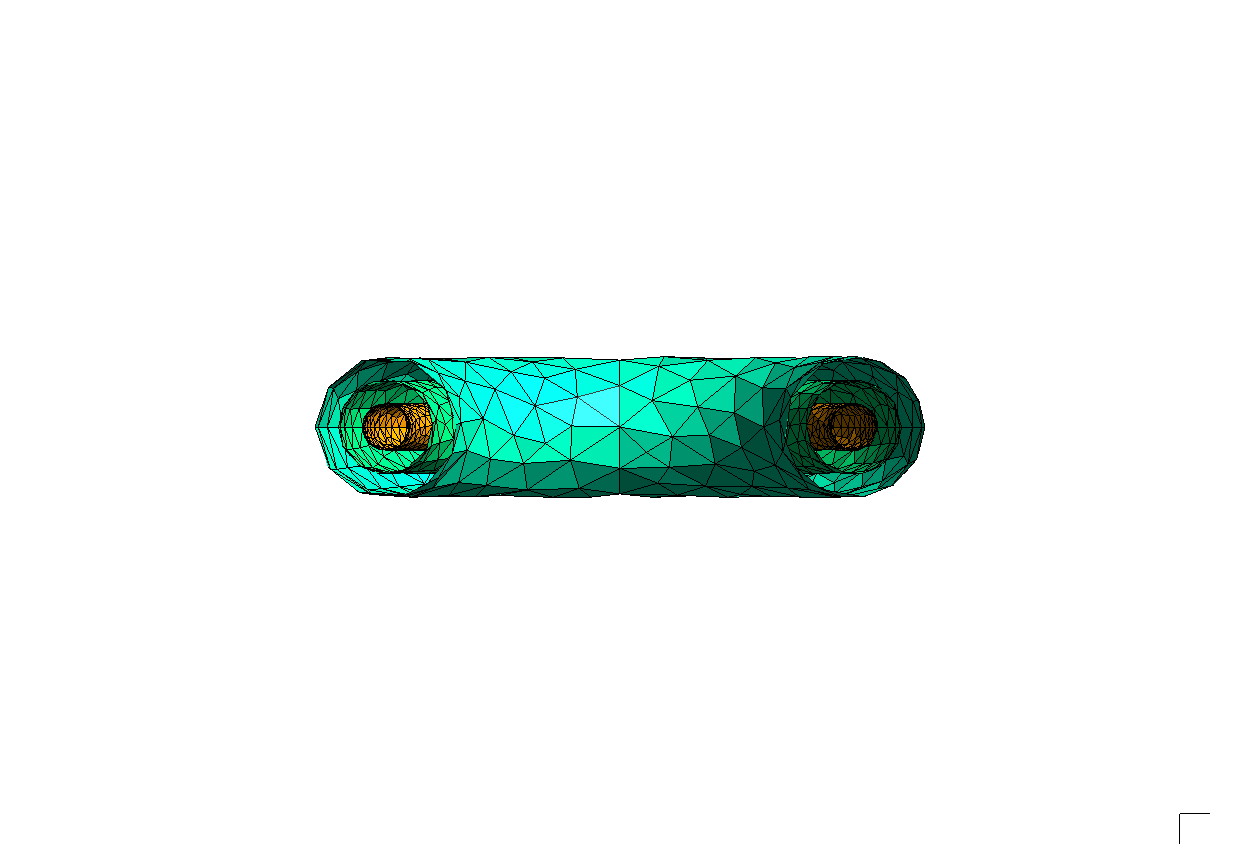

In [15]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(curvature_target=10)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)

display(Image("mesh.png", width=800))

## Run an OpenMC Tally

Here, we model, mesh, and run a flux tally on our sample geometry using OpenMC.

In [16]:
from pathlib import Path

import numpy as np
import openmc
import openmc.stats

import stellarmesh as sm

with tempfile.TemporaryDirectory() as tmpdirname:
    tmp_path = Path(tmpdirname)

    geometry = build_torus_geometry()
    mesh = sm.SurfaceMesh.from_geometry(
        geometry, sm.OCCSurfaceOptions(tol_angular_deg=0.5)
    )
    dagmc_model = sm.DAGMCModel.from_mesh(mesh)
    dagmc_model.write(tmp_path / "dagmc.h5m")

    mat1 = openmc.Material(name="a")
    mat1.add_nuclide("Fe56", 1)
    mat1.set_density("g/cm3", 1)
    mat2 = openmc.Material(name="b")
    mat2.add_nuclide("Be9", 1)
    mat2.set_density("g/cm3", 1)
    materials = openmc.Materials([mat1, mat2])

    universe = openmc.DAGMCUniverse(tmp_path / "dagmc.h5m").bounded_universe()
    openmc_geometry = openmc.Geometry(universe)

    source = openmc.IndependentSource()
    source.space = openmc.stats.CylindricalIndependent(
        openmc.stats.Discrete([10], [1]),
        openmc.stats.Uniform(0, 2 * np.pi),
        openmc.stats.Discrete([0], [1]),
    )
    source.energy = openmc.stats.Discrete([14e6], [1])

    settings = openmc.Settings()
    settings.batches = 5
    settings.inactive = 0
    settings.particles = 100
    settings.run_mode = "fixed source"
    settings.source = source

    mat_filter = openmc.MaterialFilter(materials)
    tally = openmc.Tally(name="flux")
    tally.filters = [mat_filter]
    tally.scores = ["flux"]
    tallies = openmc.Tallies([tally])

    model = openmc.Model(openmc_geometry, materials, settings, tallies)
    model.export_to_model_xml(path=tmp_path)
    output_file = model.run(cwd=str(tmp_path))
    with openmc.StatePoint(output_file) as sp:
        tally = sp.get_tally(name="flux")
        flux = tally.mean.flatten()
        print("Flux:", flux)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################